In [1]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [3]:
class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.mask = config.mask
        # flash attention is way faster than MultiHeadAttention, requires Pytorch >= 2.0
        assert hasattr(torch.nn.functional, 'scaled_dot_product_attention'), "Flash Attention requires PyTorch >= 2.0"


    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=self.mask)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y
    
class CrossAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.linear_enc = nn.Linear(config.n_embd*2, config.n_embd, bias=config.bias)
        self.c_attn = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.mask = config.mask
        assert hasattr(torch.nn.functional, 'scaled_dot_product_attention'), "Flash Attention requires PyTorch >= 2.0"
        

    def forward(self, x, encoded_data):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # In cross attention the key and value are calculated using the data from the encoder, while the query value is calculated using the decoder data.
        # The rest of the code is the same.
        q = self.c_attn(x)
        k = self.c_attn(encoded_data)
        v = self.c_attn(encoded_data)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=self.mask)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

In [4]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [5]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = SelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.cross_attn = CrossAttention(config)
        self.ln_3 = LayerNorm(config.n_embd, bias=config.bias)
        self.ln_4 = LayerNorm(config.n_embd, bias=config.bias)
        self.linear = nn.Linear(config.n_embd, config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x, encoded_x):
        # We add x to each layer to skip connections.
        x = x + self.attn(self.ln_1(x))
        x = x + self.ln_2(self.cross_attn(x, encoded_x))
        x = x + self.mlp(self.ln_3(x))
        return x
    
class EncoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [6]:
@dataclass
class DecoderConfig:
    block_size: int = 30
    vocab_size: int = 4096
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 72
    dropout: float = 0.0
    bias: bool = False # True: bias in Linears and LayerNorms. False: a bit better and faster
    mask: bool = True # Whether or not the attention is causal. (the future tokens get masked away)
    
@dataclass
class EncoderConfig:
    block_size: int = 30
    vocab_size: int = 4096
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 72
    dropout: float = 0.0
    bias: bool = False # True: bias in Linears and LayerNorms. False: a bit better and faster
    mask: bool = False # Whether or not the attention is causal. (the future tokens get masked away)

The mask flag (on the encoder) is important to understand. Basically if mask is set to True the attention will be casual, which means that it will not use future information in the attention calculation. If it is set to False it will use the whole sequence to perform the attention. Setting the encoder attention as casual would mean to loose the meaning of the experiment, which is to encode high variance known events to create a more realistic simulation.

On the decoder the mask must always be True.

In [134]:
class Generator(nn.Module):

    def __init__(self, config, encoder_config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        assert config.n_layer == encoder_config.n_layer
        self.config = config
        self.encoder_config = encoder_config
        self.base_std = 1/np.sqrt(config.n_embd) # The base std for initialization is calculated by taking the inverse of the sqrt of the embedding size
        
        # We do not need token embeddings in the encoder.
        self.encoder = nn.ModuleDict(dict(
            f_ln = nn.Linear(encoder_config.block_size, encoder_config.block_size),
            wpe = nn.Embedding(encoder_config.block_size, encoder_config.n_embd),
            drop = nn.Dropout(encoder_config.dropout),
            h = nn.ModuleList([EncoderBlock(encoder_config) for _ in range(encoder_config.n_layer)]),
            ln_f = LayerNorm(encoder_config.block_size, bias=encoder_config.bias),
        ))
        
        self.decoder = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # This applies weight tying. It is useful to tie the weights of the head that generates the logit tokens with the token embedding layer.
        # The encoder does not need this since it does not generate tokens.
        self.decoder.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=self.base_std/np.sqrt(5 * config.n_layer)) # Why 5? 3 operations on each Block + 2 operations on each Encoder Block

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.decoder.wpe.weight.numel()
            n_params -= self.encoder.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.base_std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.base_std)

    def forward(self, idx, vols, targets=None):
        device = idx.device
        b, t = idx.size()
        b2, t2 = vols.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        pos_vol = torch.arange(0, t2, dtype=torch.long, device=device) # shape (t)

        tok_emb = self.decoder.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.decoder.wpe(pos) # position embeddings of shape (t, n_embd)
        
        pos_emb_vol = self.encoder.wpe(pos_vol) # position embeddings of shape (t, n_embd)
        x = self.decoder.drop(tok_emb + pos_emb)
        
        ln_x_vol = self.encoder.ln_f(self.encoder.f_ln(vols)) # We substitute the embedding lookup for a linear transformation
        x_vol = self.encoder.drop(ln_x_vol.unsqueeze(2) + pos_emb_vol.unsqueeze(0)) # We fix the dimensions so the result is of shape (b, t, n_embd)

        for idx in range(self.config.n_layer):
            encoded_x = self.encoder.h[idx](x_vol) # For every block we encode the data and then pass it to the decoder
            x = self.decoder.h[idx](x, encoded_x)
        x = self.decoder.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # during inference we only need to apply the head to the temporal dimension
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.decoder.wpe.weight = nn.Parameter(self.decoder.wpe.weight[:block_size])
        for block in self.decoder.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]
    
    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer
    
    @torch.no_grad()
    def generate(self, idx, vols, bins, rets, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        assert idx.size(1) >= self.config.block_size and vols.size(1) >= self.encoder_config.block_size
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            idx_vols = int(np.clip(idx.size(1) - self.config.block_size, 0, np.inf))
            vols_cond = vols if vols.size(1) <= self.encoder_config.block_size else vols[:, idx_vols:idx_vols+self.encoder_config.block_size]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond, vols_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
            ret = torch.from_numpy(np.array([bins[idx_next.item()]], dtype=np.float32))
            ret = ret.to(device)
            rets = torch.cat((rets, ret))
            mean_ret = torch.mean(rets[-252:])
            if idx.size(1) > vols.size(1):
                print("No future variance provided, auto calculating...")
                # This means we have more returns than variances, so we append the variance of the last token.
                var = torch.abs(ret - mean_ret)[None, ...]
                vols = torch.cat((vols, torch.where(var < 0.03, 0, var)), dim=1)

        return idx

In [8]:
def custom_space(start, end, num):
    """
    Function that creates a custom space that has more bins in the center of the space and fewer bins on the extremes.
    """
    # Create a linear space between -1 and 1
    linear_space = np.linspace(-1, 1, num)
    # Apply the inverse hyperbolic tangent function to spread values at the end
    nonlinear_space = np.arctanh(linear_space * 0.9)  # Multiplier to avoid infinity at the edges
    # Normalize the space to the range [0, 1]
    normalized_space = (nonlinear_space - nonlinear_space.min()) / (nonlinear_space.max() - nonlinear_space.min())
    # Scale and shift the transformed space to the desired range
    transformed_space = start + normalized_space * (end - start)
    return transformed_space

In [10]:
import pandas as pd
import numpy as np

vocab_size = 4096
print(f'The vocab size is set to {vocab_size}. This means the initial expected error will be: {-np.log(1/vocab_size)}')

data_df = pd.read_csv('data/stocks/returns.csv', index_col=0)
data_df.index = pd.to_datetime(data_df.index)

min_change = data_df.values.flatten().min()
max_change = data_df.values.flatten().max()

bins = custom_space(min_change*1.1, max_change*1.1, vocab_size)
print(f'The max and min changes are {max_change} | {min_change}, the step is {bins[vocab_size//2] - bins[(vocab_size//2)+1]}')

total_tokens = 0
for col in data_df.columns:
    first_idx = np.nonzero(np.diff(data_df[col].values))[0][0]
    total_tokens += len(data_df[first_idx:-252*2])
print("The total amount of tokens is", total_tokens)

The vocab size is set to 4096. This means the initial expected error will be: 8.317766166719343
The max and min changes are 0.4239713774597498 | -0.5188165387472147, the step is -0.00015481848888287963
The total amount of tokens is 75149


In [12]:
out_dir = 'generation-out'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

dataset = 'stocks'
gradient_accumulation_steps = 1 # We have very few tokens, so we don't use gradient accumulation
batch_size = 64
block_size = 30 # Context of the 30 previous trading days

tokens_per_iter = gradient_accumulation_steps * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

# model specs
n_layer = 6
n_head = 6
n_embd = 72
dropout = 0.2

learning_rate = 1e-3 # a small network can have a higher lr
n_epochs = 10
max_iters = int((total_tokens/tokens_per_iter)*n_epochs)
warmup_iters = int(max_iters*0.01) # not super necessary potentially
lr_decay_iters = max_iters - warmup_iters # make equal to max_iters usually

print(f"We will train this dataset over {max_iters} steps")

min_lr = 1e-4 # learning_rate / 10 usually
beta1 = 0.9
beta2 = 0.99 # make a bit bigger because number of tokens per iter is small
weight_decay = 1e-1

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
bias = False
decay_lr = True
eval_only = False # if True, script exits right after the first eval
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging

tokens per iteration will be: 1,920
We will train this dataset over 391 steps


In [13]:
#device = 'cpu' # Set device to cpu for testing the model
device = 'cuda'

In [14]:
from contextlib import nullcontext

os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
# This is needed for reproducibility in case we run this code with different GPUS
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

In [16]:
import pandas as pd
import numpy as np

datas = {}
val_datas = {}
def get_batch(split, device_type='cuda'):
    # We get a random asset from the returns matrix
    col = np.random.choice(data_df.columns)
    if col not in datas:
        data = pd.DataFrame(data_df[col].copy())
        # We calculate the var of the asset based on the return diff vs the mean of the last 365 days. We get the absolute value to avoid bias.
        x_arr = abs(data[col] - data[col].rolling(pd.Timedelta(days=365)).mean())
        # We only take the values that are greater than 0.01 from the mean, which are more likely to represent market reactions to events and avoid the noise.
        data['var'] = np.where(x_arr < 0.03, 0, x_arr)
        # Since not all the assets in the returns matrix start on the same day we find on which date the asset starts having market data.
        # This just means that the first day the asset has returns will be its first day on the market.
        first_idx = np.nonzero(np.diff(data[col].values))[0][0]
        # We save the last two years of data to test
        # We transform the returns values into tokens
        data[col] = np.digitize(data[col].values, bins)
        datas[col] = data[first_idx:-(252*2)].copy()
        val_datas[col] = data[-(252*2):].copy()
        
    if split == 'train':
        data = datas[col].copy()
    elif split == 'val':
        data = val_datas[col].copy()
        
    # We find random indexes for sequences equal to the batch size.
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[col].values[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[col].values[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    z = torch.stack([torch.from_numpy((data['var'].values[i:i+block_size]).astype(np.float32)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y, z = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True), z.pin_memory().to(device, non_blocking=True)
    else:
        x, y, z = x.to(device), y.to(device), z.to(device)
    return x, y, z

In [135]:
iter_num = 0
best_val_loss = 1e9

meta_vocab_size = vocab_size

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # init the model

model_args['vocab_size'] = meta_vocab_size
# This sets the matrix calculations precision to tensorfloat 32, which speeds up computation by a lot, with negligible cost for precision
# Check https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html for more info
torch.set_float32_matmul_precision('high')
dconf = DecoderConfig(**model_args)
econf = EncoderConfig(**model_args)
model = Generator(dconf, econf)

number of parameters: 1.20M


In [18]:
X, Y, Z = get_batch('train', 'cpu') # Test line to see if the model works on one pass.
#model(X, Z)

In [138]:
# Test line to see if the generate function works
y = model.generate(
    (X[0][None, ...]), 
    torch.tensor(np.concatenate(((Z[0][None, ...]), (Z[0][:5][None, ...])), axis=1), dtype=torch.float32, device=device), 
    bins, 
    torch.tensor([0.001], dtype=torch.float32, device=device), 
    10, temperature=1, top_k=50
)

No future variance provided, auto calculating...
No future variance provided, auto calculating...
No future variance provided, auto calculating...
No future variance provided, auto calculating...
No future variance provided, auto calculating...


In [ ]:
# We pass the model to the device
model.to(device)

In [20]:
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)

checkpoint = None # free up memory

# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

num decayed parameter tensors: 76, with 1,202,148 parameters
num non-decayed parameter tensors: 57, with 4,020 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)


In [21]:
# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, Z = get_batch(split)
            with ctx:
                logits, loss = model(X, Z, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [22]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

In [23]:
X, Y, Z = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model

In [24]:
Z.size() # We check the tensors have the correct size

torch.Size([64, 30])

In [ ]:
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            # Uncomment this for checkpoint saving
            #if iter_num > 0:
            #    checkpoint = {
            #        'model': raw_model.state_dict(),
            #        'optimizer': optimizer.state_dict(),
            #        'model_args': model_args,
            #        'iter_num': iter_num,
            #        'best_val_loss': best_val_loss,
            #        'config': config,
            #    }
            #    print(f"saving checkpoint to {out_dir}")
            #    torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        with ctx:
            logits, loss = model(X, Z, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y, Z = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, norm: {norm:.4f}")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

## Tests

In [28]:
test_data = data_df.copy()

In [29]:
def from_returns_to_prices(returns, initial_price=100):
    multipliers = 1 + returns
    cumulative_multipliers = np.cumprod(multipliers)
    prices = initial_price * cumulative_multipliers
    return prices

In [30]:
def apply_pct_change(arr):
    pct_changes = np.zeros_like(arr)

    # Calculate percentage change for each element except the first one
    pct_changes[1:] = (arr[1:] - arr[:-1]) / arr[:-1]
    return pct_changes

In [117]:
from tqdm import tqdm

model.eval()
col = 'AAPL_US'
num_samples = 200 # number of simulations
max_new_tokens = 65 # number of market days simulated
temperature = 1.3 # How random the simulation is
top_k = 1000 # retain only the top_k most likely tokens, clamp others to have 0 probability
future = max_new_tokens + block_size
# We only use the last two years for testing
start_idx = -252*2
data = pd.DataFrame(data_df[col].copy())
x_arr = abs(data[col] - data[col].rolling(pd.Timedelta(days=365)).mean())
data['var'] = np.where(x_arr < 0.03, 0, x_arr)
data['vol'] = data[col].rolling(pd.Timedelta(days=365)).std()*np.sqrt(252)
rets = torch.from_numpy(data[col][-252*3:-252*2].values)
rets = rets.to(device)
data = data[-(252*2):]
data[col] = np.digitize(data[col].values, bins)
start_ids = data[col].values[start_idx:start_idx+block_size]
start_ids_vol = data['var'].values[start_idx:start_idx+block_size+max_new_tokens]
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
z = (torch.tensor(start_ids_vol, dtype=torch.half, device=device)[None, ...])
initial_price = 100 # All simulations start at the same price

# We initialize the paths to the real path
paths = np.concatenate((np.array([initial_price]), np.array(from_returns_to_prices(bins[data[col].values[start_idx:start_idx+future]])))).reshape(1, future+1)
with torch.no_grad():
    with ctx:
        for k in tqdm(range(num_samples), total=num_samples):
            y = model.generate(
                x, 
                z, 
                bins,
                rets,
                max_new_tokens, 
                temperature=temperature, 
                top_k=top_k
            )
            # We transform the tokens back to returns.
            returns = bins[y[0].tolist()]
            paths = np.concatenate((paths, np.concatenate((np.array([initial_price]), from_returns_to_prices(returns))).reshape(1, future+1)), axis=0)

100%|██████████| 200/200 [02:34<00:00,  1.29it/s]


In [129]:
# First of all we want to see if the samples generated have a high skew.
# we can take the mean of each day of each path and use it as reference.
test = data[[col, 'var']][start_idx:start_idx+future+1].copy()
test['sim'] = np.mean(paths, axis=0)
test['sim_pct'] = test['sim'].pct_change()
test.sort_values(by='var', ascending=False)[:5]

,AAPL_US,var,sim,sim_pct
2022-11-10,2914,0.088731,130.916782,0.002946
2022-10-28,2839,0.075223,129.567541,0.002060
2022-09-13,2006,0.059009,124.643410,-0.000869
2022-09-29,2068,0.049331,126.644235,0.001932
2022-11-03,2111,0.042314,130.559858,0.000961


We can clearly see the returns are not highly skewed! The mean return of the most high variance days is hovering around 0.2%!

In [118]:
pct_change_paths = paths.copy()
for idx, p in enumerate(paths):
    pct_change_paths[idx] = apply_pct_change(p)

In [120]:
# Now we want to see if the variance is encoded properly. We will take the variance that each day has across all the simulations.
# If we did this well, the encoded high variance days should be more prevalent in the top variance days.
test = data[[col, 'var']][start_idx:start_idx+future+1].copy()
test['sim_var'] = np.var(pct_change_paths, axis=0)
sorted_test = test.reset_index().sort_values(by='sim_var', ascending=False)
top_n = 10

print(f"The encoded data represents {(1-len(data[data['var'] == 0])/len(data))*100:.3f}% of the dataset.")
print(f"The high variance encoded days represent {(1-len(sorted_test[:top_n][sorted_test[:top_n]['var'] == 0])/top_n)*100:.3f}% of the top {top_n} high variance days in simulation.")

The encoded data represents 6.746% of the dataset.
The high variance encoded days represent 50.000% of the top 10 high variance days in simulation.


That's great! We can see that even though the encoded data represents barely 7% of the dataset (meaning the days that have a deviation >3% from the mean), in the simulations these high variance days represent 50% (taking the top 10).
That's exactly what we want!

In [121]:
from scipy.stats import kurtosis, skew

# Now we want to check what is the mean volatility and return in the simulations, as well as the kurtosis and the skew.

vols = np.std(pct_change_paths, axis=1)*np.sqrt(252)
rets = [(p[-1] - p[max_new_tokens]) / p[max_new_tokens] for p in paths]
print(f"The mean vol of the simulation is {np.mean(vols):.4f}, while the real volatility is {data[start_idx:future+1]['vol'].mean():.4f}")
print(f"The mean return of the simulation is {np.mean(rets):.4f}")
print(f"The simulation ranges from {np.min(vols):.4f} to {np.max(vols):.4f} for volatility, from {np.min(rets):.4f} to {np.max(rets):.4f} for returns and has a kurtosis of {kurtosis(rets):.4f} and a skew of {skew(rets):.4f}")

The mean vol of the simulation is 0.3278, while the real volatility is 0.3159
The mean return of the simulation is 0.0338
The simulation ranges from 0.2415 to 0.4547 for volatility, from -0.2865 to 0.5783 for returns and has a kurtosis of 0.9618 and a skew of 0.4823


We can see the volatility of the simulation is pretty close to the real volatility of the period!
Also we can see the mean return of the simulations is slightly positive, confirmed by the skew calculation as well.
The kurtosis is also positive, which indicates the existance of heavier tails than a normal distribution.

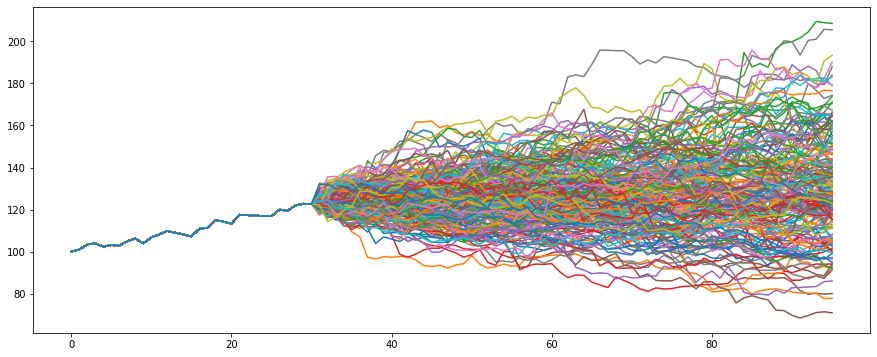

In [123]:
import matplotlib.pyplot as plt

# We can observe the simulations created.

plt.figure(figsize=(15,6))
for p in paths:
    plt.plot(p)
plt.show()

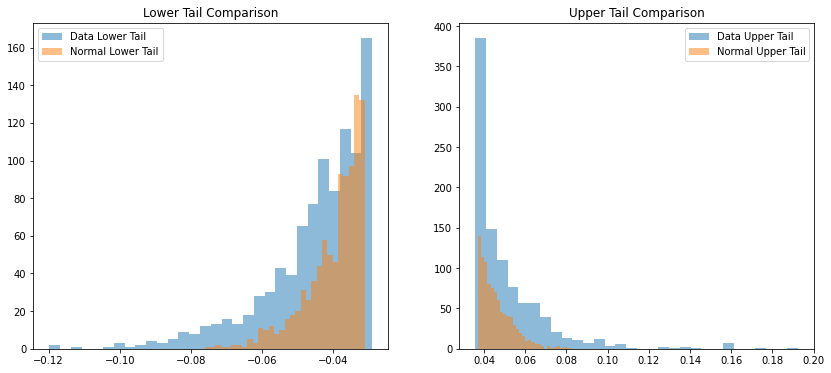

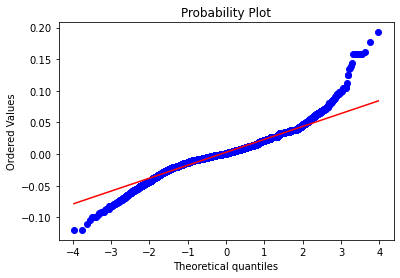

In [128]:
import scipy.stats as stats

# We finally want to see how the distribution of our simulations compare to a normal distribution.

# Calculate mean and standard deviation of the returns
mean = np.mean(pct_change_paths)
std = np.std(pct_change_paths)

# Fit a normal distribution
normal_dist = np.random.normal(mean, std, pct_change_paths.shape)

def plot_tails(data, normal_dist):
    # We want to plot the 5% tails for the normal distribution and the distribution of our simulations.
    sorted_data = np.sort(data.flatten())
    sorted_normal = np.sort(normal_dist.flatten())
    
    lower_tail_data = sorted_data[:int(0.05 * len(sorted_data))]
    upper_tail_data = sorted_data[-int(0.05 * len(sorted_data)):]
    
    lower_tail_normal = sorted_normal[:int(0.05 * len(sorted_normal))]
    upper_tail_normal = sorted_normal[-int(0.05 * len(sorted_normal)):]

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(lower_tail_data, bins=30, alpha=0.5, label='Data Lower Tail')
    plt.hist(lower_tail_normal, bins=30, alpha=0.5, label='Normal Lower Tail')
    plt.title('Lower Tail Comparison')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(upper_tail_data, bins=30, alpha=0.5, label='Data Upper Tail')
    plt.hist(upper_tail_normal, bins=30, alpha=0.5, label='Normal Upper Tail')
    plt.title('Upper Tail Comparison')
    plt.legend()

    plt.show()

def qq_plot(data):
    # Simple function to generate a qq plot of both distributions
    stats.probplot(data.flatten(), dist="norm", plot=plt)
    plt.show()

# Plot tails
plot_tails(pct_change_paths, normal_dist)

# Plot Q-Q plot
qq_plot(pct_change_paths)

We can observe fatter tails, both in the left and right.
We can also see that the right tail is both fatter and longer than the right one, which would imply that positive surprises happen more often than negative ones, and that when they happen they have more impact.

This would need to be taken with a grain of salt, since the training dataset is comprised of 10 very successful companies and that introduces a pretty significant bias to the model.

It is also possible to play with the simulation hyperparameters (temperature, top_k) to obtain different results, which would mean that the results are not very stable.